In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir('cnn'))


['sample_submission.csv', 'test.csv', 'train.csv']


In [2]:
# ucitavanje podataka za trening
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# ucitavanje podataka za test
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# y_train nam je oznaka klase, dok su u x_train uzorci i obelezja, i za to nam ne treba label
# axis=1 znaci da izbacujemo kolonu
y_train = train['label']
x_train = train.drop(labels =['label'],axis =1)

In [5]:
y_train.head()
#x_train.head()

0    1
1    0
2    1
3    4
4    0
Name: label, dtype: int64

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

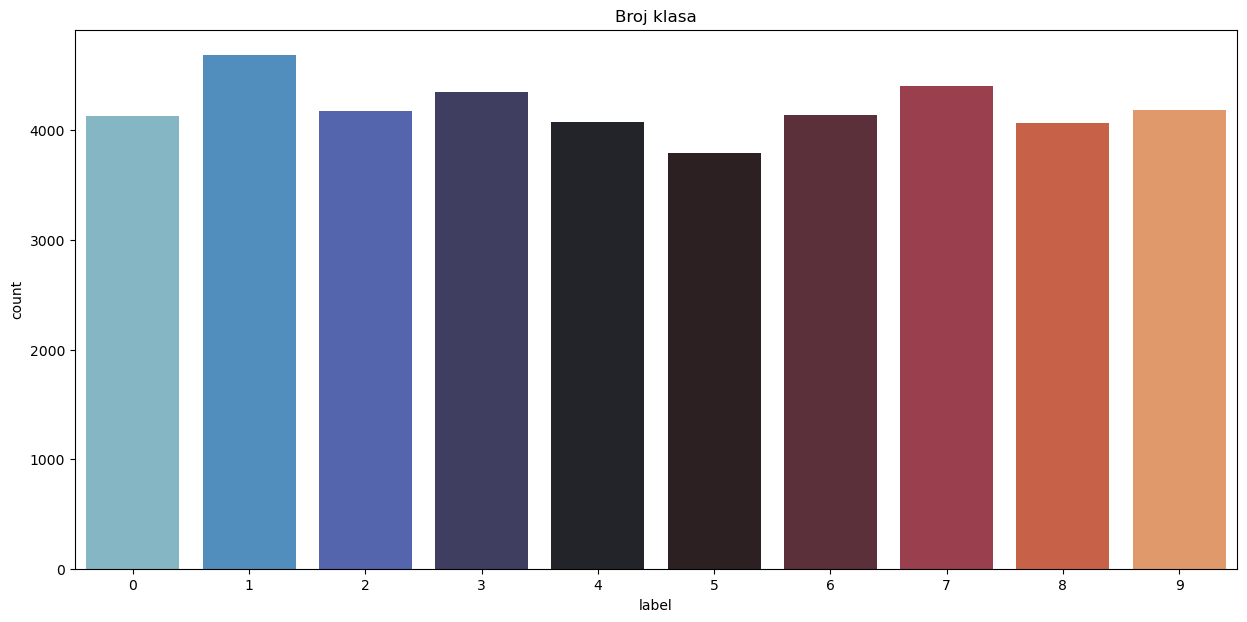

In [6]:
# proveravamo broj klasa
plt.figure(figsize=(15,7))
g = sns.countplot(x='label', data = train, palette="icefire")
plt.title('Broj klasa')
y_train.value_counts()

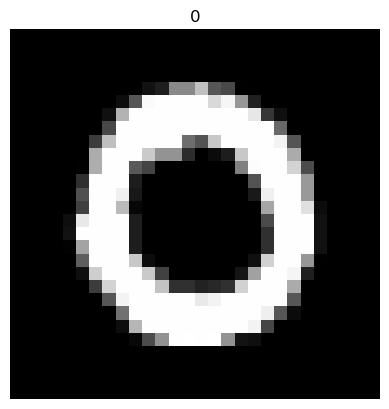

In [7]:
# plot nekih uzoraka
img = x_train.iloc[1].to_numpy()
img = img.reshape((28,28))
plt.imshow(img, cmap='gray')
plt.title(train.iloc[1,1])
plt.axis('off')
plt.show()

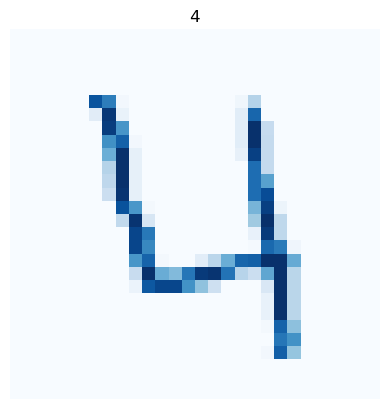

In [8]:
img = x_train.iloc[3].to_numpy()
img = img.reshape((28,28)) # reshape prikaz slike ide na koren iz broja kolona tj x
plt.imshow(img, cmap='Blues')
plt.title(train.iloc[3,0])
plt.axis('off')
plt.show()

In [9]:
# normalizacija podataka kako bi cnn radila brze
x_train = x_train / 255.0
test = test/ 255.0
print('x_train shape is ', x_train.shape)
print('x_test shape is ', test.shape)

x_train shape is  (42000, 784)
x_test shape is  (28000, 784)


In [10]:
# reshape, .values se koristi da bi x_train bio prikazan kao niz podataka
x_train = x_train.values.reshape(-1,28,28,1) # -1 automatski podesava broj uzoraaka
test = test.values.reshape(-1,28,28,1)
print('x_train shape ', x_train.shape)
print('test shape: ', test.shape)

x_train shape  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [11]:
import tensorflow as tf


In [12]:
from tensorflow.keras.utils import to_categorical
# one hot encoding, klasa 1 ce biti predstavljena kao [1,0,0,0,0,0,0,0,0,0]
y_train = to_categorical(y_train, num_classes=10)

In [13]:
# podela na trening i validacioni skup
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_val.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_val.shape)

x_train shape:  (37800, 28, 28, 1)
x_test shape:  (4200, 28, 28, 1)
y_train shape:  (37800, 10)
y_test shape:  (4200, 10)


<function matplotlib.pyplot.show(close=None, block=None)>

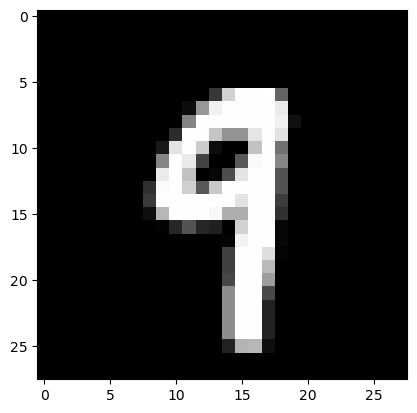

In [14]:
# neki primeri
plt.imshow(x_train[2][:,:,0], cmap ='gray')
plt.show

In [17]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [20]:
# sequ model dobar za slojeve koji imaju tacno jedan ulaz i jedan izlaz
model = Sequential()
# dodajemo konv sloj koji trazi obrasce sa 8 filtera velicine 5x5
# opcijom padding='same' dodaju se dodatni slojevi piksela oko ivica slike
# kako bi izlazna slika(feature map) bila istih dimenzija kao i ulazna
model.add(Conv2D(filters = 8, kernel_size= (5,5), padding= 'Same', activation= 'relu', input_shape=(28,28,1)))
# dodajemo pooling sloj- smanjuje dimenzije slike, zadrzava najbitnije info
# pool_size je velicina prozora, sto znaci da se slika prepolovljuje
model.add(MaxPool2D(pool_size =(2,2)))
model.add(Dropout(0.25)) #nasumicno iskljucuje 25% neurona u svkakom prolazu treninga
#time se sprecava overfitting

model.add(Conv2D(filters = 16, kernel_size=(3,3), padding ='same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2))) # stride je korak pomeranja preko slike nakon konv
model.add(Dropout(0.25))

# na kraju se dodaju potpuno povezani slojevi
model.add(Flatten())
model.add(Dense(256, activation='relu')) # prvi je skriveni sloj
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax')) # izlazni sloj koji koristi softmax za klasifikaciju

In [22]:
# definisemo optimizaciju, tj menjamo stopu ucenja mreze
optimizer = Adam(learning_rate=0.001, beta_1 =0.9, beta_2=0.999)

In [23]:
# kategorijska crossentropy, fja greske koja se koristi kad imamo vise klasa
# da bi se koristila, treba uvek uraditi hot-encoding
model.compile(optimizer = optimizer, loss= 'categorical_crossentropy', metrics=['accuracy'])

In [24]:
# npr 10 uzoraka, batch_size je 2, a epohe 3. u svakoj epohi imamo 10/2 batches, tj 
# svaki batch prolazi kroz algoritam, pa imamo 5 iteracija po epohi
epochs = 10 # sa vise epoha je bolji rezultat
batch_size= 250

In [31]:
# data augmentation- vestacko povecanje podataka tako sto se prave male izmene na slikama,
# poput pomaka, scalinga ili rotacije da bi model naucio da generalizuje obrasce umesto da uci specificne detalje na  slikama
datagen = ImageDataGenerator(featurewise_center=False, # ul sr_vred 0
                             samplewise_center=False,  # sr_vred uzorka 0
                             featurewise_std_normalization =False, # podeli ulaz sa std dataseta
                             samplewise_std_normalization=False, #podeli svaki ulaz sa svojom std
                             zca_whitening=False, # redukcija dimenzije
                             rotation_range = 10, #random rotiranje slike u range od 10 stepeni
                             zoom_range=0.1, # random zoom slike za 10%
                             width_shift_range =0.1, # random pomeri sliku horizont 10%
                             height_shift_range=0.1, # random pomeri sliku vertik 10%
                             horizontal_flip=False, # random okreni sliku
                             vertical_flip=False) # random okreni sliku
datagen.fit(x_train)

In [32]:
# fitovanje modela
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size),
                             epochs= epochs, validation_data= (x_val,y_val), steps_per_epoch=x_train.shape[0]// batch_size)

Epoch 1/10
151/151 [==============================] - 11s 73ms/step - loss: 0.1787 - accuracy: 0.9447 - val_loss: 0.0538 - val_accuracy: 0.9831
Epoch 2/10
151/151 [==============================] - 11s 72ms/step - loss: 0.1684 - accuracy: 0.9474 - val_loss: 0.0498 - val_accuracy: 0.9850
Epoch 3/10
151/151 [==============================] - 14s 90ms/step - loss: 0.1642 - accuracy: 0.9502 - val_loss: 0.0501 - val_accuracy: 0.9843
Epoch 4/10
151/151 [==============================] - 13s 87ms/step - loss: 0.1571 - accuracy: 0.9517 - val_loss: 0.0482 - val_accuracy: 0.9843
Epoch 5/10
151/151 [==============================] - 11s 75ms/step - loss: 0.1500 - accuracy: 0.9546 - val_loss: 0.0444 - val_accuracy: 0.9864
Epoch 6/10
151/151 [==============================] - 11s 72ms/step - loss: 0.1456 - accuracy: 0.9551 - val_loss: 0.0445 - val_accuracy: 0.9862
Epoch 7/10
151/151 [==============================] - 11s 71ms/step - loss: 0.1442 - accuracy: 0.9553 - val_loss: 0.0436 - val_accuracy:

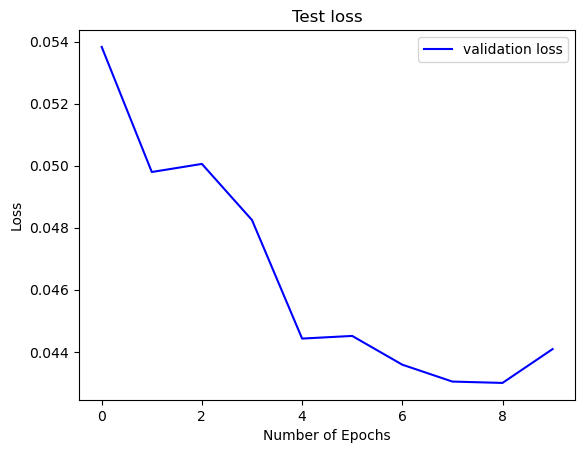

In [33]:
# evaluacija modela, predstavljanje gubitka i tacnosti za trening i validaciju
plt.plot(history.history['val_loss'], color='b',label='validation loss')
plt.title('Test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

132/132 [==============================] - 1s 4ms/step


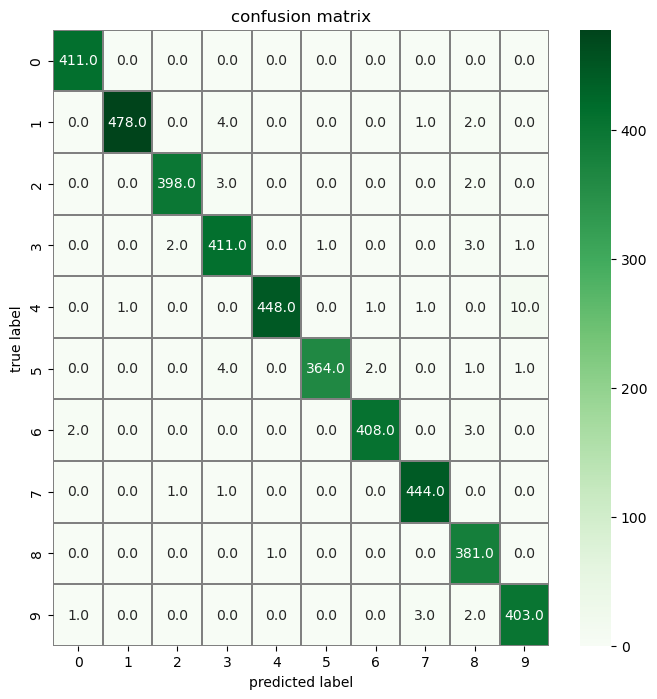

In [34]:
# matrica konfuzije
# predvidjanje klase za podatke iz skupa za validaciju
y_pred = model.predict(x_val) # y_pred sadrzi verovatnoce za svaku klasu za svaki uzorak u x_val
# pretvara se u oznaku klase koja ima najvecu vrv tako sto uzima indeks najvise verovatnoce za svaku predikciju
y_pred_classes = np.argmax(y_pred, axis=1) # predstavlja predikcije modela kao numericke vredn klasa
# y_val je one-hot vektor koji sadrzi stvarne klase, on se pretvara u numericke oznake
y_true = np.argmax(y_val, axis=1) #sadrzi prave klase za svaki primer x_val, kao numericke oznake
# matrica konfuzije
confusion_mtx = confusion_matrix(y_true,y_pred_classes)
# plot matrice
f,ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap='Greens', linecolor='gray',fmt='.1f',ax=ax)
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.title('confusion matrix')
plt.show()

132/132 [==============================] - 0s 2ms/step


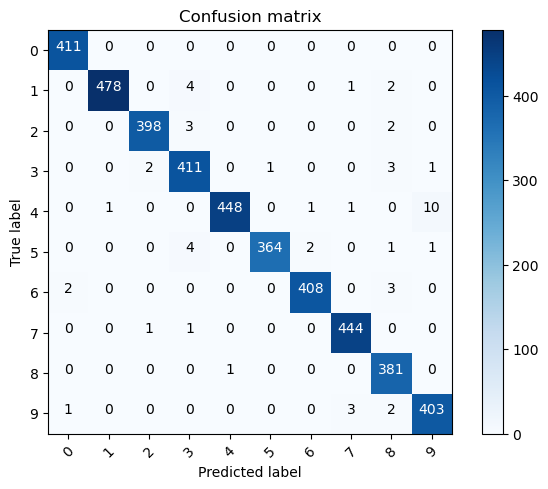

In [40]:
# nema potrebe pisati ovakvu fju, jer moze da se iskoristi sns.heatmap

def plot_confusion_matrix(cm,
                          classes,
                          normalize= False,
                          title='Confusion matrix', 
                          cmap=plt.cm.Blues,
                          fmt='.1f',
                         annot = True):
    # funkcija prikazuje i crta matricu konfuzije, norm se primenjuje normalize= True

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.

    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(x_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)
conf_mat = confusion_matrix(y_true,y_pred_classes)

plot_confusion_matrix(conf_mat, classes= range(10))

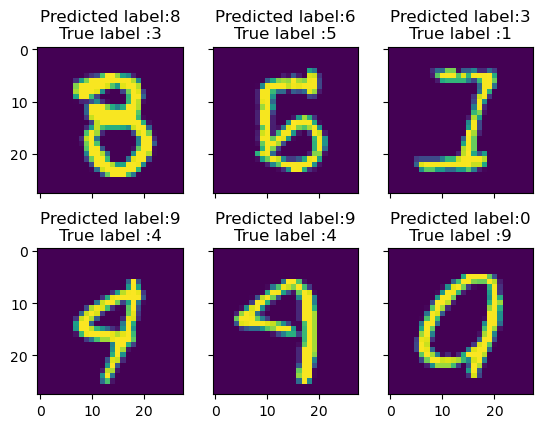

In [42]:
# prikazivanje nekih gresaka
# greska je razlika izmedju predvidjenih i stvarnih labels
errors = (y_pred_classes - y_true != 0)

y_pred_classes_errors = y_pred_classes[errors]
y_pred_errors = y_pred[errors]
y_true_errors = y_true[errors]
x_val_errors = x_val[errors]

def display_errors(errors_index, img_errors, pred_errors, obs_errors):
    # prikazuje 6 slika sa prediktovanim i stvarnim oznakama
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey= True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)))
            ax[row,col].set_title('Predicted label:{}\nTrue label :{}'.format(pred_errors[error],obs_errors[error]))
            n+=1

# verovatnoce pogresno predvidjenih brojeva
y_pred_errors_prob = np.max(y_pred_errors, axis=1)
# predvidjene verovatnoce pravih vrednosti u setu gresaka
true_prob_errors = np.diagonal(np.take(y_pred_errors, y_true_errors, axis=1))
# razlika izmedju verovatnoce predvidjene oznake i prave oznake
delta_pred_true_errors = y_pred_errors_prob - true_prob_errors

# sortirana lista delta vrv greske, indeksi gresaka sortirani prema razlici u vrv
sorted_delta_errors = np.argsort(delta_pred_true_errors)
# top 6 greski, greske gde je model bio najvise uveren u pogresnu predikciju
most_important_errors = sorted_delta_errors[-6:]
# prikaz greski
display_errors(most_important_errors, x_val_errors, y_pred_classes_errors, y_true_errors)